In [1]:
import pandas as pd
import numpy as np
import os, ast
from rdkit.Chem.rdmolfiles import MolFromMol2File
from scipy.spatial.distance import pdist
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, is_aa
from Bio.SVDSuperimposer import SVDSuperimposer
from utils import center_of_mass, mean, std

KIBA

In [10]:

LIGAND_ROOT = "kiba_klifsanalysis/klifs_ligands"
INPUT_CSV   = "proximity_threshold_results.csv"
OUT_SUMMARY      = "kiba_pooled_and_pairwise_metrics_with_COM_to_all.csv"
OUT_LONG         = "kiba_COM_pairwise_long.csv"

def load_imp_ids(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            return v if isinstance(v, list) else []
        except Exception:
            return []
    return []


def get_coords(mol):
    conf = mol.GetConformer()
    return np.array(
        [list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())],
        dtype=float
    )


def atom_masses(mol):
    return np.array([a.GetMass() for a in mol.GetAtoms()], dtype=float)


def heavy_mask(mol):
    """Boolean mask for heavy atoms (atomic number > 1)."""
    return np.array([a.GetAtomicNum() > 1 for a in mol.GetAtoms()], dtype=bool)

def compute_all_metrics(df):

    summary_rows = []
    long_rows = []
    per_lig_rows = []
    debug_printed = 0

    for pid, g in df.groupby("protein_id"):
        imp_points_all = []
        all_points_all = []
        nonimp_points_all = []

        com_imp_ligs = []
        com_all_ligs = []
        sid_list     = []
        d_imp_all_list = []
        d_nonimp_all_list = []

        n_ligs = 0

        for _, r in g.iterrows():
            sid = int(r["structure_ID"])
            lig_path = os.path.join(LIGAND_ROOT, f"ligand_{sid}.mol2")
            if not os.path.exists(lig_path):
                continue

            mol = MolFromMol2File(lig_path, removeHs=False)
            if mol is None or mol.GetNumConformers() == 0:
                continue

            coords = get_coords(mol)   # (N,3)
            masses = atom_masses(mol)  # (N,)
            maskH  = heavy_mask(mol)   # (N,)
            imp_ids = [i - 1 for i in load_imp_ids(r["mol2_atom_ids"]) if i and i > 0]
            imp_ids = [i for i in imp_ids if 0 <= i < len(maskH) and maskH[i]]
            if len(imp_ids) == 0:
                continue

            all_coords = coords[maskH]
            all_m      = masses[maskH]

            imp_coords = coords[imp_ids]
            imp_m      = masses[imp_ids]

            nonimp_mask = maskH.copy()
            nonimp_mask[imp_ids] = False
            nonimp_ids    = np.where(nonimp_mask)[0]
            nonimp_coords = coords[nonimp_ids]
            nonimp_m      = masses[nonimp_ids] if nonimp_coords.size > 0 else None
            imp_points_all.append(imp_coords)
            all_points_all.append(all_coords)
            if nonimp_coords.shape[0] > 0:
                nonimp_points_all.append(nonimp_coords)
            COM_imp = center_of_mass(imp_coords, imp_m)
            COM_all = center_of_mass(all_coords, all_m)

            if np.all(np.isfinite(COM_imp)) and np.all(np.isfinite(COM_all)):
                com_imp_ligs.append(COM_imp)
                com_all_ligs.append(COM_all)
                sid_list.append(sid)
            COM_all_for_dist    = COM_all
            COM_imp_for_dist    = COM_imp
            COM_nonimp_for_dist = center_of_mass(nonimp_coords, nonimp_m) if nonimp_coords.size > 0 else np.array([np.nan, np.nan, np.nan])

            if np.all(np.isfinite(COM_imp_for_dist)) and np.all(np.isfinite(COM_all_for_dist)):
                d_imp_all = float(np.linalg.norm(COM_imp_for_dist - COM_all_for_dist))
            else:
                d_imp_all = np.nan

            if np.all(np.isfinite(COM_nonimp_for_dist)) and np.all(np.isfinite(COM_all_for_dist)):
                d_nonimp_all = float(np.linalg.norm(COM_nonimp_for_dist - COM_all_for_dist))
            else:
                d_nonimp_all = np.nan

            d_imp_all_list.append(d_imp_all)
            d_nonimp_all_list.append(d_nonimp_all)

            per_lig_rows.append(dict(
                protein_id=pid,
                structure_ID=sid,
                d_COM_imp_to_all=d_imp_all,
                d_COM_nonimp_to_all=d_nonimp_all,
                n_imp_atoms=len(imp_ids),
                n_nonimp_atoms=int(nonimp_coords.shape[0]),
                n_all_atoms=int(all_coords.shape[0]),
            ))


            n_ligs += 1

        if n_ligs < 2 or len(com_imp_ligs) < 2 or len(com_all_ligs) < 2:
            imp_points_all_arr    = np.vstack(imp_points_all)    if imp_points_all    else np.empty((0,3))
            all_points_all_arr    = np.vstack(all_points_all)    if all_points_all    else np.empty((0,3))
            nonimp_points_all_arr = np.vstack(nonimp_points_all) if nonimp_points_all else np.empty((0,3))

            d_imp    = pdist(imp_points_all_arr)    if len(imp_points_all_arr)    >= 2 else np.array([])
            d_all    = pdist(all_points_all_arr)    if len(all_points_all_arr)    >= 2 else np.array([])
            d_nonimp = pdist(nonimp_points_all_arr) if len(nonimp_points_all_arr) >= 2 else np.array([])

            mean_pw_imp    = float(np.mean(d_imp))    if d_imp.size    else np.nan
            mean_pw_all    = float(np.mean(d_all))    if d_all.size    else np.nan
            mean_pw_nonimp = float(np.mean(d_nonimp)) if d_nonimp.size else np.nan

            ratio_pw = (mean_pw_imp / mean_pw_all) if (np.isfinite(mean_pw_imp) and np.isfinite(mean_pw_all) and mean_pw_all > 0) else np.nan
            ratio_imp_nonimp = (mean_pw_imp / mean_pw_nonimp) if (np.isfinite(mean_pw_imp) and np.isfinite(mean_pw_nonimp) and mean_pw_nonimp > 0) else np.nan
            mean_COM_imp_to_all    = mean(d_imp_all_list)
            std_COM_imp_to_all     = std(d_imp_all_list)
            mean_COM_nonimp_to_all = mean(d_nonimp_all_list)
            std_COM_nonimp_to_all  = std(d_nonimp_all_list)

            summary_rows.append(dict(
                protein_id=pid,
                n_ligands=n_ligs,
                mean_pw_COM_imp_between_ligs=np.nan,
                mean_pw_COM_all_between_ligs=np.nan,
                ratio_pw_COM_imp_all_between_ligs=np.nan,
                mean_pw_imp=mean_pw_imp,
                mean_pw_nonimp=mean_pw_nonimp,
                mean_pw_all=mean_pw_all,
                ratio_pw=ratio_pw,
                ratio_imp_nonimp=ratio_imp_nonimp,
                n_imp_atoms=int(imp_points_all_arr.shape[0]),
                n_nonimp_atoms=int(nonimp_points_all_arr.shape[0]),
                n_all_atoms=int(all_points_all_arr.shape[0]),
                mean_COM_imp_to_all=mean_COM_imp_to_all,
                std_COM_imp_to_all=std_COM_imp_to_all,
                mean_COM_nonimp_to_all=mean_COM_nonimp_to_all,
                std_COM_nonimp_to_all=std_COM_nonimp_to_all,
            ))
            continue
        com_imp_arr = np.vstack(com_imp_ligs)
        com_all_arr = np.vstack(com_all_ligs)

        for (i, j) in combinations(range(len(sid_list)), 2):
            d_imp = float(np.linalg.norm(com_imp_arr[i] - com_imp_arr[j]))
            d_all = float(np.linalg.norm(com_all_arr[i] - com_all_arr[j]))
            long_rows.append(dict(
                protein_id=pid,
                metric="COM_imp_between_ligs",
                distance=d_imp,
                lig_i_sid=int(sid_list[i]),
                lig_j_sid=int(sid_list[j])
            ))
            long_rows.append(dict(
                protein_id=pid,
                metric="COM_all_between_ligs",
                distance=d_all,
                lig_i_sid=int(sid_list[i]),
                lig_j_sid=int(sid_list[j])
            ))

        d_com_imp = pdist(com_imp_arr)
        d_com_all = pdist(com_all_arr)
        mean_pw_COM_imp_between_ligs  = mean(d_com_imp)
        mean_pw_COM_all_between_ligs  = mean(d_com_all)
        ratio_pw_COM_imp_all_between_ligs = (
            mean_pw_COM_imp_between_ligs / mean_pw_COM_all_between_ligs
            if (np.isfinite(mean_pw_COM_imp_between_ligs) and
                np.isfinite(mean_pw_COM_all_between_ligs) and
                mean_pw_COM_all_between_ligs > 0)
            else np.nan
        )
        imp_points_all_arr    = np.vstack(imp_points_all)    if imp_points_all    else np.empty((0,3))
        all_points_all_arr    = np.vstack(all_points_all)    if all_points_all    else np.empty((0,3))
        nonimp_points_all_arr = np.vstack(nonimp_points_all) if nonimp_points_all else np.empty((0,3))

        d_imp    = pdist(imp_points_all_arr)    if len(imp_points_all_arr)    >= 2 else np.array([])
        d_all    = pdist(all_points_all_arr)    if len(all_points_all_arr)    >= 2 else np.array([])
        d_nonimp = pdist(nonimp_points_all_arr) if len(nonimp_points_all_arr) >= 2 else np.array([])

        mean_pw_imp    = float(np.mean(d_imp))    if d_imp.size    else np.nan
        mean_pw_all    = float(np.mean(d_all))    if d_all.size    else np.nan
        mean_pw_nonimp = float(np.mean(d_nonimp)) if d_nonimp.size else np.nan

        ratio_pw = (mean_pw_imp / mean_pw_all) if (np.isfinite(mean_pw_imp) and np.isfinite(mean_pw_all) and mean_pw_all > 0) else np.nan
        ratio_imp_nonimp = (mean_pw_imp / mean_pw_nonimp) if (np.isfinite(mean_pw_imp) and np.isfinite(mean_pw_nonimp) and mean_pw_nonimp > 0) else np.nan
        mean_COM_imp_to_all    = mean(d_imp_all_list)
        std_COM_imp_to_all     = std(d_imp_all_list)
        mean_COM_nonimp_to_all = mean(d_nonimp_all_list)
        std_COM_nonimp_to_all  = std(d_nonimp_all_list)

        summary_rows.append(dict(
            protein_id=pid,
            n_ligands=len(sid_list),
            mean_pw_COM_imp_between_ligs=mean_pw_COM_imp_between_ligs,
            mean_pw_COM_all_between_ligs=mean_pw_COM_all_between_ligs,
            ratio_pw_COM_imp_all_between_ligs=ratio_pw_COM_imp_all_between_ligs,
            mean_pw_imp=mean_pw_imp,
            mean_pw_nonimp=mean_pw_nonimp,
            mean_pw_all=mean_pw_all,
            ratio_pw=ratio_pw,
            ratio_imp_nonimp=ratio_imp_nonimp,
            n_imp_atoms=int(imp_points_all_arr.shape[0]),
            n_nonimp_atoms=int(nonimp_points_all_arr.shape[0]),
            n_all_atoms=int(all_points_all_arr.shape[0]),
            mean_COM_imp_to_all=mean_COM_imp_to_all,
            std_COM_imp_to_all=std_COM_imp_to_all,
            mean_COM_nonimp_to_all=mean_COM_nonimp_to_all,
            std_COM_nonimp_to_all=std_COM_nonimp_to_all,
        ))

    return (
        pd.DataFrame(summary_rows),
        pd.DataFrame(long_rows),
        pd.DataFrame(per_lig_rows),
    )
if __name__ == "__main__":
    df = pd.read_csv(INPUT_CSV)
    df["mol2_atom_ids"] = df["mol2_atom_ids"].apply(load_imp_ids)

    ligand_key = "Drug_ID" if "Drug_ID" in df.columns else ("smiles" if "smiles" in df.columns else None)
    lig_counts = df.groupby("protein_id")[ligand_key].nunique()
    keep = set(lig_counts[lig_counts >= 2].index)
    df = df[df["protein_id"].isin(keep)].copy()

    print(f"Total proteins in input: {df['protein_id'].nunique()}")
    print(f"Proteins with >=2 ligands: {len(keep)}")
    print(f"Rows retained: {len(df)}")

    out_summary, out_long, out_per_lig = compute_all_metrics(df)

    out_summary.to_csv(OUT_SUMMARY, index=False)
    out_long.to_csv(OUT_LONG, index=False)

    print(f"\nSaved per-protein summary to: {OUT_SUMMARY}  (rows={len(out_summary)})")
    print(f"Saved long-form pairwise COM distances to: {OUT_LONG}  (rows={len(out_long)})")





Total proteins in input: 69
Proteins with >=2 ligands: 69
Rows retained: 718

Saved per-protein summary to: kiba_pooled_and_pairwise_metrics_with_COM_to_all.csv  (rows=69)
Saved long-form pairwise COM distances to: kiba_COM_pairwise_long.csv  (rows=22658)


C:\Users\mrina\AppData\Local\Temp\ipykernel_56144\1719444130.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


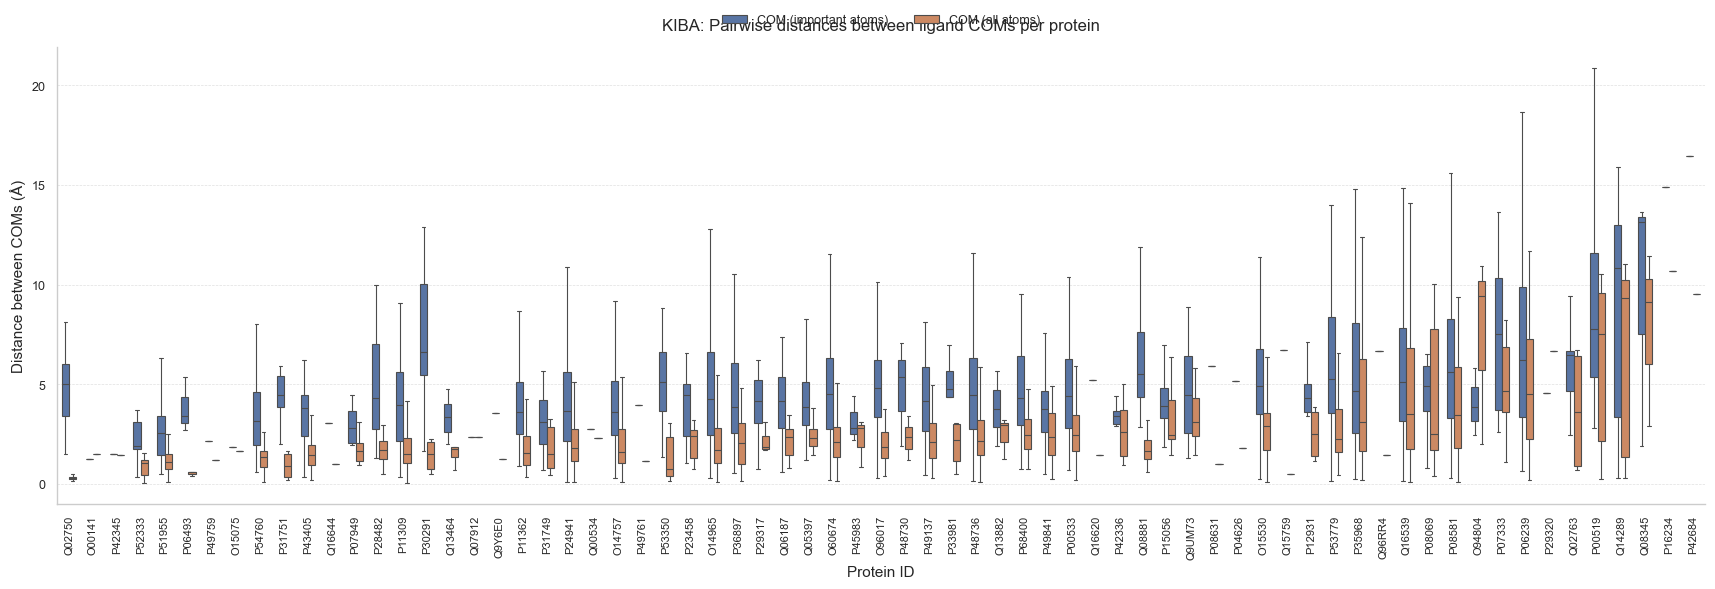

In [3]:
LONG_CSV    = "kiba_COM_pairwise_long.csv"
SAVE = "COM_KIBA"
df = pd.read_csv(LONG_CSV)
df = df.dropna(subset=["distance"])

metric_labels = {
    "COM_imp_between_ligs": "COM (important atoms)",
    "COM_all_between_ligs": "COM (all atoms)",
}
df["metric"] = df["metric"].map(metric_labels).fillna(df["metric"])

HUE_ORDER = ["COM (important atoms)", "COM (all atoms)"]
order = (
    df.groupby("protein_id")["distance"]
      .median()
      .sort_values(ascending=True)
      .index
      .tolist()
)

n_proteins = len(order)
width = max(10, min(0.25 * n_proteins, 40))
sns.set_theme(style="whitegrid", context="paper")
sns.set_style({"axes.spines.right": False, "axes.spines.top": False})
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "xtick.labelsize": 8,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})
fig, ax = plt.subplots(figsize=(width, 6))

sns.boxplot(
    data=df,
    x="protein_id",
    y="distance",
    hue="metric",
    hue_order=HUE_ORDER,
    order=order,
    orient="v",
    showfliers=False,
    linewidth=0.8,
    width=0.6,
    dodge=True,
    ax=ax,
)

ax.set_title("KIBA: Pairwise distances between ligand COMs per protein", pad=12)
ax.set_ylabel("Distance between COMs (Å)")
ax.set_xlabel("Protein ID")

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
ax.set_axisbelow(True)
ax.legend(
    title="",
    bbox_to_anchor=(0.5, 1.02),
    loc="lower center",
    ncol=2,
    frameon=False,
)
fig.tight_layout()
fig.savefig(f"{SAVE}_vertical_grouped.png", dpi=600, bbox_inches="tight")
plt.show()



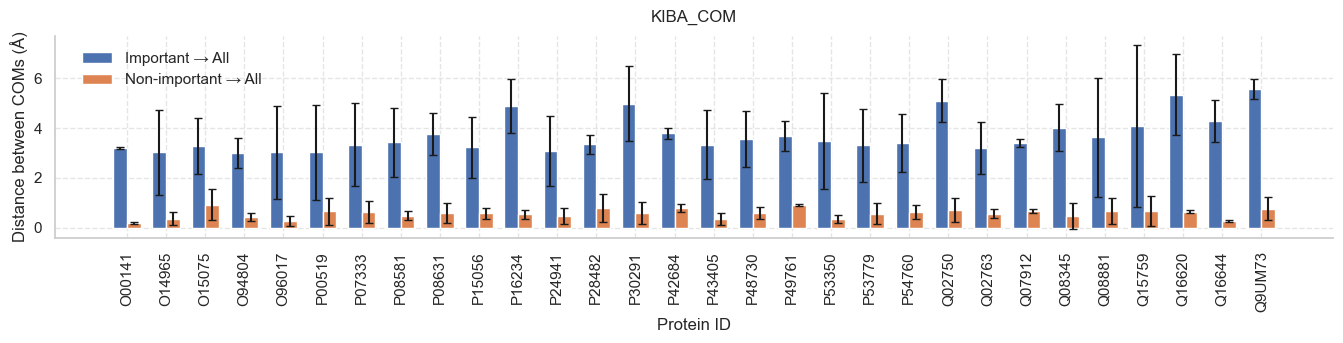

Saved per-protein bar plot with error bars to: kiba_COM_protein.png


In [11]:
OUT_BAR_PLOT = "kiba_COM_protein.png"


def plot_per_protein_bar(per_protein_df,
                         out_path=OUT_BAR_PLOT):
    df = per_protein_df.sort_values(
        "mean_COM_imp_to_all", ascending=False
    ).head(30).copy()
    df = df.sort_values("protein_id")

    proteins = df["protein_id"].astype(str).values
    mean_imp = df["mean_COM_imp_to_all"].values
    std_imp  = df["std_COM_imp_to_all"].values
    mean_non = df["mean_COM_nonimp_to_all"].values
    std_non  = df["std_COM_nonimp_to_all"].values

    x = np.arange(len(proteins))
    width = 0.35
    fig_width = max(12, 0.45 * len(proteins))
    fig_height = 3.5
    plt.rcParams.update({
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.alpha": 0.5,
        "font.size": 9,
    })

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    ax.bar(
        x - width / 2,
        mean_imp,
        width,
        yerr=std_imp,
        capsize=3,
        label="Important \u2192 All",
    )
    ax.bar(
        x + width / 2,
        mean_non,
        width,
        yerr=std_non,
        capsize=3,
        label="Non-important \u2192 All",
    )

    ax.set_xticks(x)
    ax.set_xticklabels(proteins, rotation=90)

    ax.set_ylabel("Distance between COMs (Å)")
    ax.set_xlabel("Protein ID")
    ax.set_title("KIBA_COM", pad=10)

    ax.legend(
        title="",
        loc="upper left",
        bbox_to_anchor=(0.01, 0.99),
        frameon=False,
    )

    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"Saved per-protein bar plot with error bars to: {out_path}")

summary_df = pd.read_csv(OUT_SUMMARY)
plot_per_protein_bar(summary_df, out_path=OUT_BAR_PLOT)


GLASS

In [12]:
GLASS_PDB_ROOT   = "GLASS/cocrystal_pdb_files"
INPUT_CSV        = "proximity_glass.csv"
OUT_SUMMARY      = "glass_pooled_and_pairwise_metrics.csv"
OUT_LONG         = "glass_COM_pairwise_long1.csv"


def parse_lig_atom_ids(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return json.loads(x)
        except Exception:
            try:
                return ast.literal_eval(x)
            except Exception:
                return []
    return []

def atom_is_heavy(bio_atom):
    el = (bio_atom.element or "").strip().upper()
    return el not in ("H", "D", "T")

def ca_catalog(structure, only_chain_id=None, include_icode=True):

    out = {}
    model = next(structure.get_models())
    for chain in model:
        if only_chain_id is not None and chain.id != only_chain_id:
            continue
        for res in chain:
            if not is_aa(res, standard=True):
                continue
            if "CA" in res:
                hetflag, resseq, icode = res.get_id()
                if include_icode:
                    out[(chain.id, resseq, icode)] = res["CA"]
                else:
                    out[(chain.id, resseq)] = res["CA"]
    return out

def intersect_ca_coords(ref_ca, mob_ca):
    keys = sorted(set(ref_ca.keys()).intersection(mob_ca.keys()))
    if len(keys) < 3:
        return None, None
    ref_xyz = np.array([ref_ca[k].get_coord() for k in keys], dtype=float)
    mob_xyz = np.array([mob_ca[k].get_coord() for k in keys], dtype=float)
    return ref_xyz, mob_xyz

def apply_transform_to_structure(structure, rot, tran):
    for model in structure:
        for chain in model:
            for res in chain:
                for atom in res:
                    atom.transform(rot, tran)

def select_ligand_residue(structure, chain_id, resi_int, resn):
    model = next(structure.get_models())
    chain = next((c for c in model if c.id == chain_id), None)
    if chain is None:
        return None
    for res in chain:
        hetflag, resseq, icode = res.get_id()
        if not (isinstance(hetflag, str) and hetflag.startswith("H")):
            continue
        if res.get_resname().strip().upper() == str(resn).strip().upper() and resseq == resi_int:
            return res
    return None

def collect_imp_atoms_and_residues(structure, lig_atom_dicts):
    imp_atoms = []
    residues_used = []
    for d in lig_atom_dicts:
        chain = d.get("chain"); resi = d.get("resi"); resn = d.get("resn"); name = d.get("name")
        if None in (chain, resi, resn, name):
            continue
        try:
            resi_int = int(str(resi).strip())
        except Exception:
            continue
        res = select_ligand_residue(structure, chain, resi_int, resn)
        if res is None or name not in res:
            continue
        a = res[name]
        if atom_is_heavy(a):
            imp_atoms.append(a)
            if res not in residues_used:
                residues_used.append(res)
    return imp_atoms, residues_used

def residue_heavy_atoms(residue):
    return [a for a in residue if atom_is_heavy(a)]

def atoms_to_numpy(atoms):
    if not atoms:
        return np.empty((0, 3), dtype=float)
    return np.array([a.get_coord() for a in atoms], dtype=float)

def get_ligand_residues_by_code(structure, lig_code):
    lig_code = (lig_code or "").strip().upper()
    if not lig_code:
        return []
    out = []
    model = next(structure.get_models())
    for chain in model:
        for res in chain:
            hetflag, resseq, icode = res.get_id()
            if isinstance(hetflag, str) and hetflag.startswith("H"):
                if res.get_resname().strip().upper() == lig_code:
                    out.append(res)
    return out

def residue_heavy_atoms_list(res_list):
    atoms = []
    for res in res_list:
        atoms.extend(a for a in res if atom_is_heavy(a))
    return atoms

def pick_ligand_instance(structure, lig_code, lig_atom_dicts):
    cands = get_ligand_residues_by_code(structure, lig_code)
    if not cands:
        return []

    wanted = set()
    for d in (lig_atom_dicts or []):
        ch = d.get("chain"); resi = d.get("resi"); resn = (d.get("resn") or "").strip().upper()
        if ch is not None and resi is not None and resn == (lig_code or "").strip().upper():
            try:
                wanted.add((str(ch), int(str(resi).strip())))
            except Exception:
                pass
    matched = [res for res in cands if (res.get_parent().id, res.get_id()[1]) in wanted]
    if matched:
        return matched
    ref_atoms = []
    model = next(structure.get_models())
    for d in (lig_atom_dicts or []):
        ch = d.get("chain"); resi = d.get("resi"); resn = d.get("resn"); name = d.get("name")
        if None in (ch, resi, resn, name):
            continue
        try:
            resi_int = int(str(resi).strip())
        except Exception:
            continue
        chain = next((c for c in model if c.id == ch), None)
        if chain is None:
            continue
        res = next((r for r in chain if isinstance(r.get_id()[0], str)
                    and r.get_id()[0].startswith("H")
                    and r.get_resname().strip().upper()==(lig_code or "").strip().upper()
                    and r.get_id()[1]==resi_int), None)
        if res is not None and name in res:
            a = res[name]
            if atom_is_heavy(a):
                ref_atoms.append(a)
    if ref_atoms and len(cands) > 1:
        ref_xyz = np.array([a.get_coord() for a in ref_atoms], float)
        ref_com = ref_xyz.mean(axis=0)
        def cand_com(res):
            xyz = np.array([a.get_coord() for a in res if atom_is_heavy(a)], float)
            return xyz.mean(axis=0) if len(xyz) else np.array([np.inf, np.inf, np.inf])
        cands.sort(key=lambda r: np.linalg.norm(cand_com(r) - ref_com))
        return [cands[0]]
    return [cands[0]]

def pocket_ca_catalog_for_chain(structure, ligand_atoms, chain_id, radius=8.0):
    if not ligand_atoms or not chain_id:
        return {}
    lig_xyz = np.array([a.get_coord() for a in ligand_atoms], float)
    model = next(structure.get_models())
    out = {}
    chain = next((c for c in model if c.id == chain_id), None)
    if chain is None:
        return {}
    for res in chain:
        if not is_aa(res, standard=True) or "CA" not in res:
            continue
        ca = res["CA"]
        dmin = np.linalg.norm(lig_xyz - ca.get_coord(), axis=1).min()
        if dmin <= radius:
            hetflag, resseq, icode = res.get_id()
            out[(resseq, icode)] = ca
    return out

def main():
    df = pd.read_csv(INPUT_CSV)
   
    df["structure_ID"] = df["structure_ID"].astype(str).str.strip()
    df["lig_atom_ids"] = df["lig_atom_ids"].apply(parse_lig_atom_ids)
    df["ligand_pdb_code"] = df["ligand_pdb_code"].astype(str).str.strip().str.upper()

    lig_counts = df.groupby("Target_ID")["structure_ID"].nunique().reset_index()
    lig_counts = lig_counts.rename(columns={"structure_ID": "n_ligands"})
    multi_targets = set(lig_counts.loc[lig_counts["n_ligands"] >= 2, "Target_ID"])
    df = df[df["Target_ID"].isin(multi_targets)].copy()

    print(f"Total targets in dataset: {lig_counts.shape[0]}")
    print(f"Targets with >=2 ligands: {len(multi_targets)}")
    print(f"Filtered dataset size: {df.shape[0]} rows\n")

    parser = PDBParser(QUIET=True)
    summary_rows, long_rows = [], []
    skipped_rows = []
    per_lig_rows = []  
    debug_printed = 0

    for tid, g in df.groupby("Target_ID"):
        ref_row = g.iloc[0]
        ref_sid = str(ref_row['structure_ID'])
        ref_pdb = os.path.join(GLASS_PDB_ROOT, f"{ref_sid}.pdb")
        if not os.path.exists(ref_pdb):
            continue

        try:
            ref_struct = parser.get_structure(f"ref_{ref_sid}", ref_pdb)
        except Exception as e:
            continue
        lig_code_ref = str(ref_row.get("ligand_pdb_code", "")).strip().upper()


        ref_lig_res = pick_ligand_instance(ref_struct, lig_code_ref, ref_row["lig_atom_ids"])
        ref_lig_atoms = residue_heavy_atoms_list(ref_lig_res)
        ref_chain = ref_lig_res[0].get_parent().id if ref_lig_res else None

        ref_ca_global = ca_catalog(ref_struct, only_chain_id=ref_chain, include_icode=True) if ref_chain else ca_catalog(ref_struct, include_icode=True)
        if len(ref_ca_global) < 3:
            continue
        imp_points_all, all_points_all, nonimp_points_all = [], [], []
        com_imp_ligs, com_all_ligs, sid_list, mode_list_for_pairs = [], [], [], []
        all_alignment_modes = []
        d_imp_all_list = []
        d_nonimp_all_list = []

        for _, r in g.iterrows():
            mob_sid = str(r['structure_ID'])
            pdb_path = os.path.join(GLASS_PDB_ROOT, f"{mob_sid}.pdb")
            if not os.path.exists(pdb_path):
                continue

            try:
                mob_struct = parser.get_structure(mob_sid, pdb_path)
            except Exception as e:
                continue
           
            lig_code_mob = str(r.get("ligand_pdb_code", "")).strip().upper()


            mob_lig_res = pick_ligand_instance(mob_struct, lig_code_mob, r["lig_atom_ids"])
            mob_lig_atoms = residue_heavy_atoms_list(mob_lig_res)
            mob_chain = mob_lig_res[0].get_parent().id if mob_lig_res else None
            aligned = False
            alignment_mode = None
            pocket_info = None
            if ref_lig_atoms and mob_lig_atoms and ref_chain and mob_chain:
                ref_ca_prefit = ca_catalog(ref_struct, only_chain_id=ref_chain, include_icode=True)
                mob_ca_prefit = ca_catalog(mob_struct, only_chain_id=mob_chain, include_icode=True)
                pre_ref_xyz, pre_mob_xyz = intersect_ca_coords(ref_ca_prefit, mob_ca_prefit)
                if pre_ref_xyz is not None and len(pre_ref_xyz) >= 3:
                    svd0 = SVDSuperimposer(); svd0.set(pre_ref_xyz, pre_mob_xyz); svd0.run()
                    rot0, tran0 = svd0.get_rotran()
                    apply_transform_to_structure(mob_struct, rot0, tran0)
                ref_pock = pocket_ca_catalog_for_chain(ref_struct, ref_lig_atoms, ref_chain, radius=20.0)
                mob_pock = pocket_ca_catalog_for_chain(mob_struct, mob_lig_atoms, mob_chain, radius=20.0)
                p_keys = sorted(set(ref_pock).intersection(mob_pock))
                if len(p_keys) >= 8:
                    ref_xyz = np.array([ref_pock[k].get_coord() for k in p_keys], float)
                    mob_xyz = np.array([mob_pock[k].get_coord() for k in p_keys], float)
                    svd_p = SVDSuperimposer(); svd_p.set(ref_xyz, mob_xyz); svd_p.run()
                    rot_p, tran_p = svd_p.get_rotran(); rms_p = svd_p.get_rms()
                    pocket_info = (len(p_keys), rms_p)
                    if rms_p <= 3.0:
                        apply_transform_to_structure(mob_struct, rot_p, tran_p)
                        aligned = True
                        alignment_mode = "pocket"
            if not aligned:
                mob_ca_global = ca_catalog(mob_struct, only_chain_id=mob_chain, include_icode=True) if mob_chain else ca_catalog(mob_struct, include_icode=True)
                ref_xyz_g, mob_xyz_g = intersect_ca_coords(ref_ca_global, mob_ca_global)
                if ref_xyz_g is None:
                    continue
                svd = SVDSuperimposer(); svd.set(ref_xyz_g, mob_xyz_g); svd.run()
                rot, tran = svd.get_rotran()
                rms = svd.get_rms()
                n_match = len(ref_xyz_g)
                if n_match < 10 or rms > 3.5:
                    continue
                apply_transform_to_structure(mob_struct, rot, tran)
                alignment_mode = "global_chain" if mob_chain else "global_all"
            else:
                n_match, rms = (pocket_info[0], pocket_info[1]) if pocket_info else (None, None)

            all_alignment_modes.append(alignment_mode)

            lig_dicts = r["lig_atom_ids"]
            imp_atoms, imp_residues_from_dicts = collect_imp_atoms_and_residues(mob_struct, lig_dicts)

            chosen_lig_residues = mob_lig_res if mob_lig_res else imp_residues_from_dicts
            if not chosen_lig_residues:
                continue

            all_heavy = []
            for res in chosen_lig_residues:
                all_heavy.extend(residue_heavy_atoms(res))
            all_heavy = list({id(a): a for a in all_heavy}.values())
            nonimp_atoms = [a for a in all_heavy if a not in imp_atoms]

            imp_xyz     = atoms_to_numpy(imp_atoms)
            all_xyz     = atoms_to_numpy(all_heavy)
            nonimp_xyz  = atoms_to_numpy(nonimp_atoms)

            if imp_xyz.shape[0] > 0:
                imp_points_all.append(imp_xyz)
            if all_xyz.shape[0] > 0:
                all_points_all.append(all_xyz)
            if nonimp_xyz.shape[0] > 0:
                nonimp_points_all.append(nonimp_xyz)
            if imp_xyz.shape[0] > 0 and all_xyz.shape[0] > 0:
                COM_imp = center_of_mass(imp_xyz, [a.element for a in imp_atoms])
                COM_all = center_of_mass(all_xyz, [a.element for a in all_heavy])
                if np.all(np.isfinite(COM_imp)) and np.all(np.isfinite(COM_all)):
                    com_imp_ligs.append(COM_imp)
                    com_all_ligs.append(COM_all)
                    sid_list.append(mob_sid)
                    mode_list_for_pairs.append(alignment_mode)
            COM_all_for_dist = center_of_mass(all_xyz, [a.element for a in all_heavy]) if all_xyz.size > 0 else np.array([np.nan, np.nan, np.nan])
            COM_imp_for_dist = center_of_mass(imp_xyz, [a.element for a in imp_atoms]) if imp_xyz.size > 0 else np.array([np.nan, np.nan, np.nan])
            COM_non_for_dist = center_of_mass(nonimp_xyz, [a.element for a in nonimp_atoms]) if nonimp_xyz.size > 0 else np.array([np.nan, np.nan, np.nan])

            if np.all(np.isfinite(COM_imp_for_dist)) and np.all(np.isfinite(COM_all_for_dist)):
                d_imp_all = float(np.linalg.norm(COM_imp_for_dist - COM_all_for_dist))
            else:
                d_imp_all = np.nan

            if np.all(np.isfinite(COM_non_for_dist)) and np.all(np.isfinite(COM_all_for_dist)):
                d_nonimp_all = float(np.linalg.norm(COM_non_for_dist - COM_all_for_dist))
            else:
                d_nonimp_all = np.nan

            d_imp_all_list.append(d_imp_all)
            d_nonimp_all_list.append(d_nonimp_all)

            per_lig_rows.append(dict(
                Target_ID=tid,
                structure_ID=mob_sid,
                d_COM_imp_to_all=d_imp_all,
                d_COM_nonimp_to_all=d_nonimp_all,
                n_imp_atoms=len(imp_atoms),
                n_nonimp_atoms=len(nonimp_atoms),
                n_all_atoms=len(all_heavy),
                alignment_mode=alignment_mode,
            ))


        def pooled_stats_and_append(n_aligned_pairs=True):
            imp_arr = np.vstack(imp_points_all) if imp_points_all else np.empty((0,3))
            all_arr = np.vstack(all_points_all) if all_points_all else np.empty((0,3))
            non_arr = np.vstack(nonimp_points_all) if nonimp_points_all else np.empty((0,3))
            mean_pw_imp = mean(pdist(imp_arr)) if len(imp_arr) >= 2 else np.nan
            mean_pw_all = mean(pdist(all_arr)) if len(all_arr) >= 2 else np.nan
            mean_pw_nonimp = mean(pdist(non_arr)) if len(non_arr) >= 2 else np.nan
            ratio_pw = mean_pw_imp / mean_pw_all if np.isfinite(mean_pw_imp) and np.isfinite(mean_pw_all) and mean_pw_all > 0 else np.nan
            ratio_imp_nonimp = mean_pw_imp / mean_pw_nonimp if np.isfinite(mean_pw_imp) and np.isfinite(mean_pw_nonimp) and mean_pw_nonimp > 0 else np.nan
            n_pocket = sum(1 for m in all_alignment_modes if m == "pocket")
            n_gchain = sum(1 for m in all_alignment_modes if m == "global_chain")
            n_gall   = sum(1 for m in all_alignment_modes if m == "global_all")

            summary_rows.append(dict(
                Target_ID=tid, n_ligands=len(sid_list),
                n_aligned=len(all_alignment_modes),
                n_pocket=n_pocket, n_global_chain=n_gchain, n_global_all=n_gall,
                mean_COM_imp_to_all=mean(d_imp_all_list),
                std_COM_imp_to_all=std(d_imp_all_list),
                mean_COM_nonimp_to_all=mean(d_nonimp_all_list),
                std_COM_nonimp_to_all=std(d_nonimp_all_list),
                mean_pw_COM_imp_between_ligs=(np.nan if not n_aligned_pairs else mean_pw_COM_imp_between_ligs),
                mean_pw_COM_all_between_ligs=(np.nan if not n_aligned_pairs else mean_pw_COM_all_between_ligs),
                ratio_pw_COM_imp_all_between_ligs=(np.nan if not n_aligned_pairs else ratio_pw_COM_imp_all_between_ligs),
                mean_pw_imp=mean_pw_imp, mean_pw_nonimp=mean_pw_nonimp,
                mean_pw_all=mean_pw_all, ratio_pw=ratio_pw,
                ratio_imp_nonimp=ratio_imp_nonimp,
                n_imp_atoms=int(imp_arr.shape[0]),
                n_nonimp_atoms=int(non_arr.shape[0]),
                n_all_atoms=int(all_arr.shape[0]),
            ))

        if len(com_imp_ligs) < 2:
            mean_pw_COM_imp_between_ligs = np.nan
            mean_pw_COM_all_between_ligs = np.nan
            ratio_pw_COM_imp_all_between_ligs = np.nan
            pooled_stats_and_append(n_aligned_pairs=False)
            continue

        com_imp_arr = np.vstack(com_imp_ligs)
        com_all_arr = np.vstack(com_all_ligs)
        for (i, j) in combinations(range(len(sid_list)), 2):
            d_imp = float(np.linalg.norm(com_imp_arr[i] - com_imp_arr[j]))
            d_all = float(np.linalg.norm(com_all_arr[i] - com_all_arr[j]))
            long_rows.append(dict(
                Target_ID=tid, metric="COM_imp_between_ligs",
                distance=d_imp, lig_i_sid=sid_list[i], lig_j_sid=sid_list[j],
                mode_i=mode_list_for_pairs[i], mode_j=mode_list_for_pairs[j]
            ))
            long_rows.append(dict(
                Target_ID=tid, metric="COM_all_between_ligs",
                distance=d_all, lig_i_sid=sid_list[i], lig_j_sid=sid_list[j],
                mode_i=mode_list_for_pairs[i], mode_j=mode_list_for_pairs[j]
            ))

        d_com_imp, d_com_all = pdist(com_imp_arr), pdist(com_all_arr)
        mean_pw_COM_imp_between_ligs = mean(d_com_imp)
        mean_pw_COM_all_between_ligs = mean(d_com_all)
        ratio_pw_COM_imp_all_between_ligs = (
            mean_pw_COM_imp_between_ligs / mean_pw_COM_all_between_ligs
            if np.isfinite(mean_pw_COM_imp_between_ligs)
            and np.isfinite(mean_pw_COM_all_between_ligs)
            and mean_pw_COM_all_between_ligs > 0
            else np.nan
        )

        pooled_stats_and_append(n_aligned_pairs=True)
    out_summary = pd.DataFrame(summary_rows)
    out_long_df = pd.DataFrame(long_rows)
 

    out_summary.to_csv(OUT_SUMMARY, index=False)
    out_long_df.to_csv(OUT_LONG, index=False)
   

    print(f"\nSaved summary to {OUT_SUMMARY} ({len(out_summary)} rows)")
    print(f"Saved long-form COM distances to {OUT_LONG} ({len(out_long_df)} rows)")


if __name__ == "__main__":
    main()


Total targets in dataset: 82
Targets with >=2 ligands: 42
Filtered dataset size: 152 rows


Saved summary to glass_pooled_and_pairwise_metrics.csv (42 rows)
Saved long-form COM distances to glass_COM_pairwise_long1.csv (414 rows)


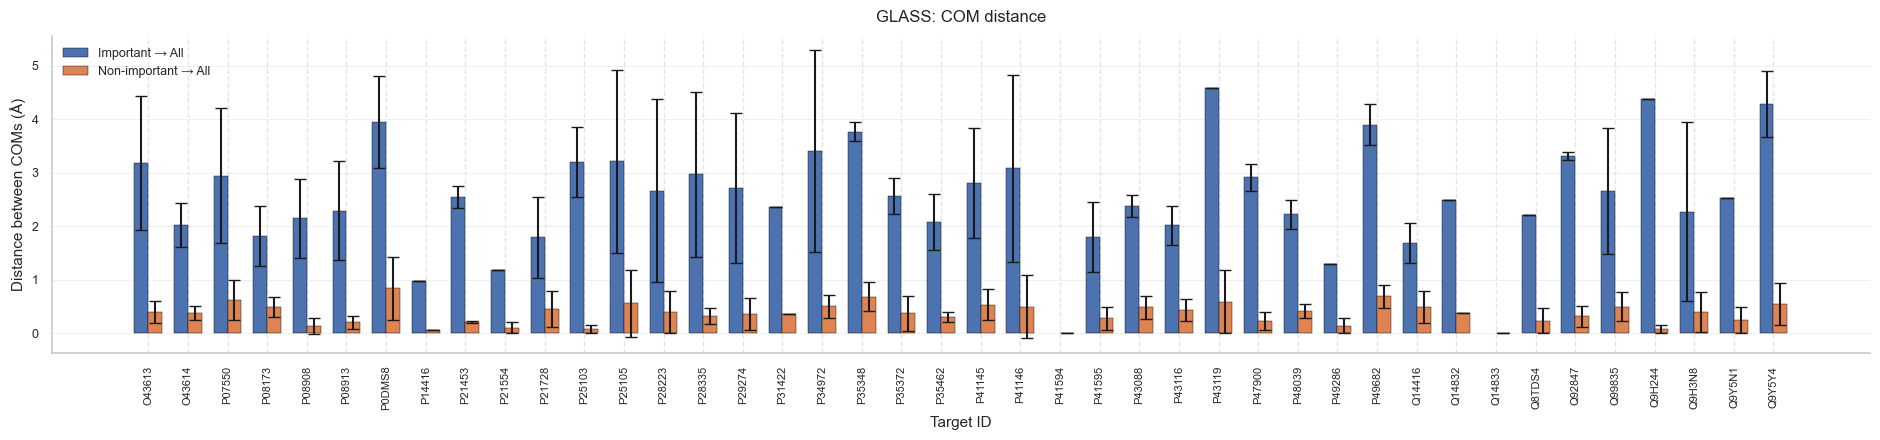

Saved per-target bar plot with error bars to: glass_COM.png


In [13]:
OUT_SUMMARY  = "glass_pooled_and_pairwise_metrics.csv"
OUT_BAR_PLOT = "glass_COM.png"


def plot_per_target_bar(per_target_df,
                        out_path=OUT_BAR_PLOT):

    plt.rcParams.update({
        "font.size": 10,
        "axes.labelsize": 11,
        "axes.titlesize": 12,
        "xtick.labelsize": 8,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
    })
    per_target_df = per_target_df.sort_values("Target_ID")

    targets = per_target_df["Target_ID"].astype(str).values
    mean_imp = per_target_df["mean_COM_imp_to_all"].values
    std_imp  = per_target_df["std_COM_imp_to_all"].values
    mean_non = per_target_df["mean_COM_nonimp_to_all"].values
    std_non  = per_target_df["std_COM_nonimp_to_all"].values

    x = np.arange(len(targets))
    width = 0.35
    fig_width = max(7, 0.45 * len(targets))
    fig_height = 4.5
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    ax.bar(x - width/2, mean_imp, width,
           yerr=std_imp, capsize=4,
           label="Important → All", edgecolor="black", linewidth=0.3)
    ax.bar(x + width/2, mean_non, width,
           yerr=std_non, capsize=4,
           label="Non-important → All", edgecolor="black", linewidth=0.3)

    ax.set_xticks(x)
    ax.set_xticklabels(targets, rotation=90)
    ax.set_ylabel("Distance between COMs (Å)")
    ax.set_xlabel("Target ID")
    ax.set_title("GLASS: COM distance", pad=10)
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    ax.set_axisbelow(True)

    ax.legend(frameon=False)

    fig.tight_layout()
    fig.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.show()

    print(f"Saved per-target bar plot with error bars to: {out_path}")

summary_df = pd.read_csv(OUT_SUMMARY)
plot_per_target_bar(summary_df, out_path=OUT_BAR_PLOT)


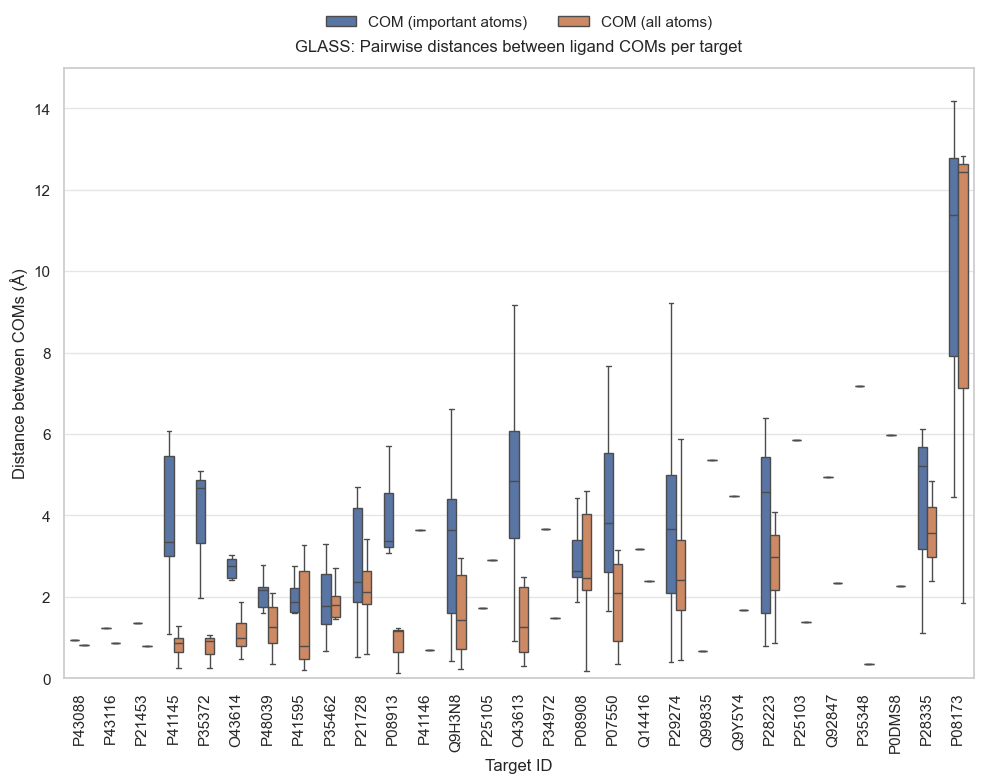

<Figure size 640x480 with 0 Axes>

In [14]:
LONG_CSV   = "glass_COM_pairwise_long1.csv"   
SAVE_PREFIX = "glass_com_between_ligs"

df = pd.read_csv(LONG_CSV)
df = df.dropna(subset=["distance"])

metric_labels = {
    "COM_imp_between_ligs": "COM (important atoms)",
    "COM_all_between_ligs": "COM (all atoms)",
}
df["metric"] = df["metric"].map(metric_labels).fillna(df["metric"])
HUE_ORDER = ["COM (important atoms)", "COM (all atoms)"]

df["Target_ID"] = df["Target_ID"].astype(str)

order = (
    df.groupby("Target_ID")["distance"]
      .median()
      .sort_values(ascending=True)
      .index
      .tolist()
)
order_plot = order[:-2]
df_plot = df[df["Target_ID"].isin(order_plot)].copy()

n_targets = len(order_plot)
width = max(10, min(0.25 * n_targets, 40))

sns.set_theme(style="whitegrid", context="notebook")
plt.figure(figsize=(width, 8))
ax = sns.boxplot(
    data=df_plot,
    x="Target_ID",
    y="distance",
    hue="metric",
    hue_order=HUE_ORDER,
    order=order_plot,
    orient="v",
    showfliers=False,
    linewidth=1.0,
    width=0.6,
    dodge=True
)

ax.set_title("GLASS: Pairwise distances between ligand COMs per target", pad=12)
ax.set_xlabel("Target ID")
ax.set_ylabel("Distance between COMs (Å)")
ax.legend(title="", bbox_to_anchor=(0.5, 1.04), loc="lower center",
          ncol=2, frameon=False)

plt.xticks(rotation=90)
ax.set_ylim(0, 15)
plt.ylim(0, 15)

plt.tight_layout()
plt.show()
plt.savefig(f"{SAVE_PREFIX}_vertical_grouped.png", dpi=300, bbox_inches="tight")



